#  Q-learning

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
* https://en.wikipedia.org/wiki/Q-learning
* https://www.baeldung.com/cs/epsilon-greedy-q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
* https://rubikscode.net/2021/07/20/introduction-to-double-q-learning/
* https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordVideo

## Задачи для совместного разбора

1\. Рассмотрите понятие Q-функции, ее применение для формирования политики агента и способов ее создания.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Обучите агента для игры в блэкджек (окружение `Blackjack-v1`), используя алгоритм Q-learning. Для создания таблицы Q-функции выясните размеры пространства состояния игры и количество возможных действий игрока и выведите эти значения на экран. Во время обучения несколько раз вычислите статистику за `print_every` последних эпизодов: количество выигранных и проигранных сессий. После завершения обучения визуализируйте полученные данные. Изучите, как выглядит Q-функция (в каких состояниях игрок будет брать карту, в каких - нет). Cыграйте `N=10000` игр, применяя стратегию, выведенную из обученной Q-функции, посчитайте и выведите на экран долю выигранных игр.

Cтратегия для выбора действия:
$$a_{t+1}(s_t) = argmax_aQ(s_t, a)$$

Правило обновления Q-функции:

![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [3]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.1 MB/s eta 0:00:00


In [1]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    print_every: int = 5000

In [4]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self._create_q_table()

    def _create_q_table(self):
        self.q_table = np.zeros((32, 11, 2, 2))

    def get_action(self, state: np.ndarray) -> int:
        """Выбор действия для текущего состояния"""
        player_sum, dealer_card, usable_ace = state
        player_sum = min(player_sum, 32) - 1
        dealer_card = dealer_card - 1
        usable_ace = int(usable_ace)

        # Жадное действие с учетом случайного выбора при равенстве Q
        return np.argmax(self.q_table[player_sum, dealer_card, usable_ace, :])

    def update_q_table(self, state: np.ndarray | tuple, new_state: np.ndarray | tuple, reward: float, action: int, done: bool) -> None:
        player_sum, dealer_card, usable_ace = state
        player_sum = min(player_sum, 32) - 1
        dealer_card = dealer_card - 1
        usable_ace = int(usable_ace)

        new_player_sum, new_dealer_card, new_usable_ace = new_state if not done else (0, 0, 0)
        new_player_sum = min(new_player_sum, 32) - 1 if not done else 0
        new_dealer_card = new_dealer_card - 1 if not done else 0
        new_usable_ace = int(new_usable_ace) if not done else 0

        future_reward = 0 if done else np.max(self.q_table[new_player_sum, new_dealer_card, new_usable_ace, :])
        target = reward + self.cfg.discount * future_reward

        self.q_table[player_sum, dealer_card, usable_ace, action] += self.cfg.lr * (
            target - self.q_table[player_sum, dealer_card, usable_ace, action]
        )

    def run_episode(self) -> float:
        done = False
        state, info = self.env.reset()
        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            self.update_q_table(state, new_state, reward, action, done)
            state = new_state

            if done:
                return reward


    def train(self):
        ep_rewards = []
        stats = []

        for ep in tqdm(range(1, self.cfg.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            if ep % self.cfg.print_every == 0:
                win_rate = sum(r > 0 for r in ep_rewards[-self.cfg.print_every:]) / self.cfg.print_every
                print(f"Episode: {ep}, Win Rate: {win_rate:.2f}")
                stats.append((ep, win_rate))

        return ep_rewards, stats

In [5]:
if __name__ == "__main__":
    # Инициализация окружения и агента
    env = gym.make("Blackjack-v1", render_mode=None)
    config = Config()
    agent = Agent(env, config)

    # Обучение агента
    rewards, statistics = agent.train()

    # Оценка стратегии
    n_test_episodes = 10_000
    wins = 0

    for _ in range(n_test_episodes):
        done = False
        state, _ = env.reset()

        while not done:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        if reward > 0:
            wins += 1

    print(f"Win rate after training: {wins / n_test_episodes:.2f}")


  6%|▌         | 5731/100000 [00:00<00:14, 6324.68it/s]

Episode: 5000, Win Rate: 0.41


 11%|█         | 10801/100000 [00:01<00:14, 6132.89it/s]

Episode: 10000, Win Rate: 0.41


 16%|█▌        | 15845/100000 [00:02<00:13, 6127.16it/s]

Episode: 15000, Win Rate: 0.41


 21%|██        | 20914/100000 [00:03<00:12, 6195.90it/s]

Episode: 20000, Win Rate: 0.41


 26%|██▌       | 25906/100000 [00:04<00:12, 6110.66it/s]

Episode: 25000, Win Rate: 0.42


 31%|███       | 30984/100000 [00:05<00:11, 6111.87it/s]

Episode: 30000, Win Rate: 0.43


 36%|███▌      | 36081/100000 [00:05<00:10, 6282.60it/s]

Episode: 35000, Win Rate: 0.42


 41%|████      | 41118/100000 [00:06<00:09, 6080.71it/s]

Episode: 40000, Win Rate: 0.42


 46%|████▌     | 46143/100000 [00:07<00:08, 6064.44it/s]

Episode: 45000, Win Rate: 0.41


 51%|█████     | 50664/100000 [00:08<00:07, 6378.69it/s]

Episode: 50000, Win Rate: 0.42


 56%|█████▌    | 55729/100000 [00:09<00:07, 6063.43it/s]

Episode: 55000, Win Rate: 0.41


 61%|██████    | 60808/100000 [00:09<00:06, 5928.14it/s]

Episode: 60000, Win Rate: 0.43


 65%|██████▌   | 65463/100000 [00:11<00:08, 3927.32it/s]

Episode: 65000, Win Rate: 0.44


 70%|███████   | 70408/100000 [00:12<00:07, 3705.30it/s]

Episode: 70000, Win Rate: 0.42


 76%|███████▌  | 75811/100000 [00:13<00:04, 5813.15it/s]

Episode: 75000, Win Rate: 0.42


 81%|████████  | 80950/100000 [00:14<00:03, 6269.17it/s]

Episode: 80000, Win Rate: 0.42


 85%|████████▌ | 85452/100000 [00:15<00:02, 5998.57it/s]

Episode: 85000, Win Rate: 0.42


 91%|█████████ | 91041/100000 [00:16<00:01, 5359.37it/s]

Episode: 90000, Win Rate: 0.41


 96%|█████████▌| 96229/100000 [00:16<00:00, 6301.02it/s]

Episode: 95000, Win Rate: 0.43


100%|██████████| 100000/100000 [00:17<00:00, 5696.92it/s]


Episode: 100000, Win Rate: 0.41
Win rate after training: 0.42


<p class="task" id="2"></p>

2\. Повторите решение предыдущей задачи, используя алгоритм $\epsilon$-greedy Q-learning. Исследуйте, как гиперпараметры и способ инициализации значений Q-функции влияют на результат.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_aQ(s_t, a)$.

Правило обновления Q-функции:
![q-learning](https://wikimedia.org/api/rest_v1/media/math/render/svg/d247db9eaad4bd343e7882ec546bf3847ebd36d8)

- [ ] Проверено на семинаре

In [6]:
from dataclasses import dataclass

@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: float = 100_000
    epsilon: float = 1.0
    final_epsilon: float = 0.3
    print_every: int = 5000

In [7]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self._create_q_table()
        self.epsilon = self.cfg.epsilon

    def _create_q_table(self):
        """Создание Q-таблицы размером 32x11x2x2"""
        self.q_table = np.zeros((32, 11, 2, 2))

    def get_action(self, state: tuple) -> int:
        """Выбор действия с использованием epsilon-greedy стратегии"""
        player_sum, dealer_card, usable_ace = state
        player_sum = min(player_sum, 32) - 1
        dealer_card = dealer_card - 1
        usable_ace = int(usable_ace)

        if np.random.rand() < self.epsilon:
            # Выбор случайного действия
            return np.random.choice([0, 1])
        else:
            # Жадное действие
            return np.argmax(self.q_table[player_sum, dealer_card, usable_ace, :])

    def update_q_table(
        self,
        state: tuple,
        new_state: tuple,
        reward: float,
        action: int,
        done: bool,
    ) -> None:
        """Обновление Q-таблицы"""
        player_sum, dealer_card, usable_ace = state
        player_sum = min(player_sum, 32) - 1
        dealer_card = dealer_card - 1
        usable_ace = int(usable_ace)

        new_player_sum, new_dealer_card, new_usable_ace = new_state if not done else (0, 0, 0)
        new_player_sum = min(new_player_sum, 32) - 1 if not done else 0
        new_dealer_card = new_dealer_card - 1 if not done else 0
        new_usable_ace = int(new_usable_ace) if not done else 0

        future_reward = 0 if done else np.max(self.q_table[new_player_sum, new_dealer_card, new_usable_ace, :])
        target = reward + self.cfg.discount * future_reward

        self.q_table[player_sum, dealer_card, usable_ace, action] += self.cfg.lr * (
            target - self.q_table[player_sum, dealer_card, usable_ace, action]
        )

    def run_episode(self) -> float:
        """Запуск одного эпизода игры"""
        done = False
        state, _ = self.env.reset()
        total_reward = 0

        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            self.update_q_table(state, new_state, reward, action, done)
            state = new_state
            total_reward += reward

        return total_reward

    def train(self):
        """Обучение агента"""
        ep_rewards = []
        stats = []
        epsilon_decay = (self.cfg.epsilon - self.cfg.final_epsilon) / self.cfg.n_episodes

        for ep in tqdm(range(1, self.cfg.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            # Плавное уменьшение epsilon
            self.epsilon = max(self.cfg.final_epsilon, self.epsilon - epsilon_decay)

            if ep % self.cfg.print_every == 0:
                win_rate = sum(r > 0 for r in ep_rewards[-self.cfg.print_every:]) / self.cfg.print_every
                print(f"Episode: {ep}, Win Rate: {win_rate:.2f}, Epsilon: {self.epsilon:.2f}")
                stats.append((ep, win_rate))

        return ep_rewards, stats




In [8]:
if __name__ == "__main__":
    # Инициализация окружения и агента
    env = gym.make("Blackjack-v1", render_mode=None)
    config = Config()
    agent = Agent(env, config)

    # Обучение агента
    rewards, statistics = agent.train()

    # Оценка стратегии
    n_test_episodes = 10_000
    wins = 0

    for _ in range(n_test_episodes):
        done = False
        state, _ = env.reset()

        while not done:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        if reward > 0:
            wins += 1

    print(f"Win rate after training: {wins / n_test_episodes:.2f}")

  6%|▌         | 5923/100000 [00:01<00:15, 6066.74it/s]

Episode: 5000, Win Rate: 0.28, Epsilon: 0.97


 11%|█         | 10658/100000 [00:01<00:15, 5868.05it/s]

Episode: 10000, Win Rate: 0.30, Epsilon: 0.93


 16%|█▌        | 15945/100000 [00:02<00:14, 5641.58it/s]

Episode: 15000, Win Rate: 0.29, Epsilon: 0.90


 21%|██        | 21160/100000 [00:03<00:13, 5689.20it/s]

Episode: 20000, Win Rate: 0.30, Epsilon: 0.86


 26%|██▌       | 25783/100000 [00:04<00:13, 5433.27it/s]

Episode: 25000, Win Rate: 0.30, Epsilon: 0.83


 31%|███       | 30669/100000 [00:05<00:11, 5783.67it/s]

Episode: 30000, Win Rate: 0.31, Epsilon: 0.79


 36%|███▌      | 36062/100000 [00:06<00:11, 5700.64it/s]

Episode: 35000, Win Rate: 0.32, Epsilon: 0.76


 41%|████      | 40754/100000 [00:07<00:10, 5787.97it/s]

Episode: 40000, Win Rate: 0.33, Epsilon: 0.72


 46%|████▌     | 45548/100000 [00:08<00:14, 3662.22it/s]

Episode: 45000, Win Rate: 0.32, Epsilon: 0.69


 50%|█████     | 50494/100000 [00:09<00:14, 3477.73it/s]

Episode: 50000, Win Rate: 0.33, Epsilon: 0.65


 56%|█████▌    | 55795/100000 [00:10<00:08, 5491.37it/s]

Episode: 55000, Win Rate: 0.35, Epsilon: 0.62


 61%|██████    | 61143/100000 [00:11<00:06, 5705.77it/s]

Episode: 60000, Win Rate: 0.35, Epsilon: 0.58


 66%|██████▌   | 65856/100000 [00:12<00:06, 5591.31it/s]

Episode: 65000, Win Rate: 0.36, Epsilon: 0.55


 71%|███████   | 70646/100000 [00:13<00:05, 5705.04it/s]

Episode: 70000, Win Rate: 0.36, Epsilon: 0.51


 76%|███████▌  | 76003/100000 [00:14<00:04, 5843.70it/s]

Episode: 75000, Win Rate: 0.36, Epsilon: 0.48


 81%|████████  | 80792/100000 [00:15<00:03, 5958.13it/s]

Episode: 80000, Win Rate: 0.36, Epsilon: 0.44


 86%|████████▌ | 86128/100000 [00:16<00:02, 5930.41it/s]

Episode: 85000, Win Rate: 0.38, Epsilon: 0.41


 91%|█████████ | 90881/100000 [00:17<00:01, 5816.95it/s]

Episode: 90000, Win Rate: 0.36, Epsilon: 0.37


 96%|█████████▌| 95662/100000 [00:17<00:00, 5717.06it/s]

Episode: 95000, Win Rate: 0.38, Epsilon: 0.34


100%|██████████| 100000/100000 [00:18<00:00, 5378.40it/s]


Episode: 100000, Win Rate: 0.38, Epsilon: 0.30
Win rate after training: 0.39


<p class="task" id="3"></p>

3\. Повторите решение задачи 1, используя алгоритм double Q-learning.

Cтратегия для выбора действия:
1. Сгенерировать число $p$ из $U(0, 1)$;
2. Если $p < \epsilon$, то выбрать действие случайным образом;
3. В противном случае $a_{t+1}(s_t) = argmax_a\left((Q^A_t + Q^B_t)(s_t, a))\right) $.

Правило обновления Q-функции:
$$
Q^A_{t+1}(s_{t}, a_{t}) = Q^A_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^B_{t}\left(s_{t+1}, {arg~max}_{a} Q^A_t(s_{t+1}, a)\right) - Q^A_{t}(s_{t}, a_{t})\right)
$$

$$
Q^B_{t+1}(s_{t}, a_{t}) = Q^B_{t}(s_{t}, a_{t}) + \alpha_{t}(s_{t}, a_{t}) \left(r_{t} + \gamma Q^A_{t}\left(s_{t+1}, {arg~max}_{a} Q^B_t(s_{t+1}, a)\right) - Q^B_{t}(s_{t}, a_{t})\right)
$$


- [ ] Проверено на семинаре

In [9]:
@dataclass
class Config:
    discount: float = 0.95
    lr: float = 0.005
    n_episodes: int = 100_000
    epsilon: float = 1.0
    final_epsilon: float = 0.3
    print_every: int = 5000


In [10]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self._create_q_tables()
        self.epsilon = self.cfg.epsilon

    def _create_q_tables(self):
        """Создание двух Q-таблиц размером 32x11x2x2"""
        self.q_table_a = np.zeros((32, 11, 2, 2))
        self.q_table_b = np.zeros((32, 11, 2, 2))

    def get_action(self, state: tuple) -> int:
        """Выбор действия с использованием epsilon-greedy стратегии и суммарных значений Q"""
        player_sum, dealer_card, usable_ace = state
        player_sum = min(player_sum, 32) - 1
        dealer_card = dealer_card - 1
        usable_ace = int(usable_ace)

        if np.random.rand() < self.epsilon:
            # Выбор случайного действия
            return np.random.choice([0, 1])
        else:
            # Жадное действие с использованием суммы Q-таблиц
            q_values = self.q_table_a[player_sum, dealer_card, usable_ace, :] + self.q_table_b[player_sum, dealer_card, usable_ace, :]
            return np.argmax(q_values)

    def update_q_tables(
        self,
        state: tuple,
        new_state: tuple,
        reward: float,
        action: int,
        done: bool,
    ) -> None:
        """Обновление Q-таблиц по правилу double Q-learning"""
        player_sum, dealer_card, usable_ace = state
        player_sum = min(player_sum, 32) - 1
        dealer_card = dealer_card - 1
        usable_ace = int(usable_ace)

        new_player_sum, new_dealer_card, new_usable_ace = new_state if not done else (0, 0, 0)
        new_player_sum = min(new_player_sum, 32) - 1 if not done else 0
        new_dealer_card = new_dealer_card - 1 if not done else 0
        new_usable_ace = int(new_usable_ace) if not done else 0

        if np.random.rand() < 0.5:
            # Обновление Q_A
            max_action_a = np.argmax(self.q_table_a[new_player_sum, new_dealer_card, new_usable_ace, :])
            future_reward = 0 if done else self.q_table_b[new_player_sum, new_dealer_card, new_usable_ace, max_action_a]
            target = reward + self.cfg.discount * future_reward
            self.q_table_a[player_sum, dealer_card, usable_ace, action] += self.cfg.lr * (
                target - self.q_table_a[player_sum, dealer_card, usable_ace, action]
            )
        else:
            # Обновление Q_B
            max_action_b = np.argmax(self.q_table_b[new_player_sum, new_dealer_card, new_usable_ace, :])
            future_reward = 0 if done else self.q_table_a[new_player_sum, new_dealer_card, new_usable_ace, max_action_b]
            target = reward + self.cfg.discount * future_reward
            self.q_table_b[player_sum, dealer_card, usable_ace, action] += self.cfg.lr * (
                target - self.q_table_b[player_sum, dealer_card, usable_ace, action]
            )

    def run_episode(self) -> float:
        """Запуск одного эпизода игры"""
        done = False
        state, _ = self.env.reset()
        total_reward = 0

        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            self.update_q_tables(state, new_state, reward, action, done)
            state = new_state
            total_reward += reward

        return total_reward

    def train(self):
        """Обучение агента"""
        ep_rewards = []
        stats = []
        epsilon_decay = (self.cfg.epsilon - self.cfg.final_epsilon) / self.cfg.n_episodes

        for ep in tqdm(range(1, self.cfg.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            # Плавное уменьшение epsilon
            self.epsilon = max(self.cfg.final_epsilon, self.epsilon - epsilon_decay)

            if ep % self.cfg.print_every == 0:
                win_rate = sum(r > 0 for r in ep_rewards[-self.cfg.print_every:]) / self.cfg.print_every
                print(f"Episode: {ep}, Win Rate: {win_rate:.2f}, Epsilon: {self.epsilon:.2f}")
                stats.append((ep, win_rate))

        return ep_rewards, stats

In [11]:
if __name__ == "__main__":
    # Инициализация окружения и агента
    env = gym.make("Blackjack-v1", render_mode=None)
    config = Config()
    agent = Agent(env, config)

    # Обучение агента
    rewards, statistics = agent.train()

    # Оценка стратегии
    n_test_episodes = 10_000
    wins = 0

    for _ in range(n_test_episodes):
        done = False
        state, _ = env.reset()

        while not done:
            action = agent.get_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

        if reward > 0:
            wins += 1

    print(f"Win rate after training: {wins / n_test_episodes:.2f}")


  6%|▌         | 5666/100000 [00:01<00:17, 5517.54it/s]

Episode: 5000, Win Rate: 0.29, Epsilon: 0.97


 11%|█         | 10792/100000 [00:01<00:15, 5613.87it/s]

Episode: 10000, Win Rate: 0.28, Epsilon: 0.93


 16%|█▌        | 15830/100000 [00:02<00:15, 5479.15it/s]

Episode: 15000, Win Rate: 0.29, Epsilon: 0.90


 21%|██        | 20565/100000 [00:03<00:20, 3895.60it/s]

Episode: 20000, Win Rate: 0.30, Epsilon: 0.86


 25%|██▌       | 25453/100000 [00:05<00:21, 3510.34it/s]

Episode: 25000, Win Rate: 0.30, Epsilon: 0.83


 31%|███       | 30962/100000 [00:06<00:14, 4882.79it/s]

Episode: 30000, Win Rate: 0.31, Epsilon: 0.79


 36%|███▌      | 35828/100000 [00:07<00:12, 5262.25it/s]

Episode: 35000, Win Rate: 0.32, Epsilon: 0.76


 41%|████      | 40859/100000 [00:08<00:10, 5544.69it/s]

Episode: 40000, Win Rate: 0.34, Epsilon: 0.72


 46%|████▌     | 45918/100000 [00:09<00:09, 5522.53it/s]

Episode: 45000, Win Rate: 0.32, Epsilon: 0.69


 51%|█████     | 50967/100000 [00:10<00:08, 5543.76it/s]

Episode: 50000, Win Rate: 0.33, Epsilon: 0.65


 56%|█████▌    | 56018/100000 [00:11<00:08, 5486.70it/s]

Episode: 55000, Win Rate: 0.33, Epsilon: 0.62


 61%|██████    | 61078/100000 [00:12<00:07, 5481.02it/s]

Episode: 60000, Win Rate: 0.35, Epsilon: 0.58


 66%|██████▌   | 65579/100000 [00:13<00:06, 5204.52it/s]

Episode: 65000, Win Rate: 0.35, Epsilon: 0.55


 71%|███████   | 70580/100000 [00:14<00:05, 5202.46it/s]

Episode: 70000, Win Rate: 0.35, Epsilon: 0.51


 76%|███████▌  | 75665/100000 [00:15<00:04, 5422.06it/s]

Episode: 75000, Win Rate: 0.35, Epsilon: 0.48


 81%|████████  | 80776/100000 [00:15<00:03, 5434.78it/s]

Episode: 80000, Win Rate: 0.36, Epsilon: 0.44


 85%|████████▌ | 85353/100000 [00:17<00:04, 3603.44it/s]

Episode: 85000, Win Rate: 0.36, Epsilon: 0.41


 91%|█████████ | 90631/100000 [00:18<00:02, 3562.24it/s]

Episode: 90000, Win Rate: 0.37, Epsilon: 0.37


 96%|█████████▌| 95844/100000 [00:19<00:00, 5302.80it/s]

Episode: 95000, Win Rate: 0.38, Epsilon: 0.34


100%|██████████| 100000/100000 [00:20<00:00, 4864.57it/s]


Episode: 100000, Win Rate: 0.38, Epsilon: 0.30
Win rate after training: 0.39


<p class="task" id="4"></p>

4\. Обучите агента для управления машиной (окружение `MountainCar-v0`) при помощи любого из рассмотренных вариантов алгоритма Q-learning. Для перехода от непрерывного пространства состояний к конечному разбейте пространство состояний на окна (количество окон выберите сами). Для определения минимальных и максимальных значений координат воспользуйтесь [информацией об окружении](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space). Во время обучения несколько раз вычислите среднее значение наград за эпизод за несколько последних эпизодов и количество успешных сессий за последние эпизоды. После завершения обучения визуализируйте полученные данные.

Сделайте несколько промежуточных видео с записью работы агента во время обучения.

- [ ] Проверено на семинаре

In [12]:
@dataclass
class Config:
    discount: float = 0.99
    lr: float = 0.1
    n_episodes: int = 20_000
    epsilon: float = 1.0
    final_epsilon: float = 0.1
    print_every: int = 500
    n_bins: int = 20  # Количество окон для дискретизации


In [13]:
class Agent:
    def __init__(self, env: gym.Env, config: Config) -> None:
        self.env = env
        self.cfg = config
        self.state_bins = self._create_bins()
        self.q_table = np.zeros((*[self.cfg.n_bins] * self.env.observation_space.shape[0], self.env.action_space.n))
        self.epsilon = self.cfg.epsilon

    def _create_bins(self):
        """Создание окон для дискретизации состояний"""
        state_bounds = zip(self.env.observation_space.low, self.env.observation_space.high)
        bins = [np.linspace(low, high, self.cfg.n_bins - 1) for low, high in state_bounds]
        return bins

    def _discretize_state(self, state: np.ndarray) -> tuple:
        """Преобразование непрерывного состояния в дискретное"""
        state_idx = [np.digitize(s, b) for s, b in zip(state, self.state_bins)]
        return tuple(state_idx)

    def get_action(self, state: np.ndarray) -> int:
        """Выбор действия с использованием epsilon-greedy стратегии"""
        state_idx = self._discretize_state(state)
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state_idx])

    def update_q_table(
        self,
        state: np.ndarray,
        new_state: np.ndarray,
        reward: float,
        action: int,
        done: bool,
    ) -> None:
        """Обновление Q-таблицы"""
        state_idx = self._discretize_state(state)
        new_state_idx = self._discretize_state(new_state)

        max_future_q = 0 if done else np.max(self.q_table[new_state_idx])
        target = reward + self.cfg.discount * max_future_q

        self.q_table[state_idx][action] += self.cfg.lr * (
            target - self.q_table[state_idx][action]
        )

    def run_episode(self) -> float:
        """Запуск одного эпизода игры"""
        state, _ = self.env.reset()
        total_reward = 0
        done = False

        while not done:
            action = self.get_action(state)
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            self.update_q_table(state, new_state, reward, action, done)
            state = new_state
            total_reward += reward

        return total_reward

    def train(self):
        """Обучение агента"""
        ep_rewards = []
        successful_episodes = 0
        epsilon_decay = (self.cfg.epsilon - self.cfg.final_epsilon) / self.cfg.n_episodes

        for ep in tqdm(range(1, self.cfg.n_episodes + 1)):
            reward = self.run_episode()
            ep_rewards.append(reward)

            # Считаем успешные эпизоды (наградой считается успешное завершение)
            if reward >= -200:  # Порог успеха зависит от окружения
                successful_episodes += 1

            # Плавное уменьшение epsilon
            self.epsilon = max(self.cfg.final_epsilon, self.epsilon - epsilon_decay)

            if ep % self.cfg.print_every == 0:
                avg_reward = np.mean(ep_rewards[-self.cfg.print_every:])
                success_rate = successful_episodes / self.cfg.print_every
                print(f"Episode: {ep}, Avg Reward: {avg_reward:.2f}, Success Rate: {success_rate:.2f}, Epsilon: {self.epsilon:.2f}")
                successful_episodes = 0  # Сбрасываем счётчик

        return ep_rewards


  3%|▎         | 507/20000 [00:11<06:36, 49.17it/s]

Episode: 500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.98


  5%|▌         | 1007/20000 [00:23<06:31, 48.52it/s]

Episode: 1000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.96


  8%|▊         | 1509/20000 [00:35<06:17, 49.03it/s]

Episode: 1500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.93


 10%|█         | 2008/20000 [00:46<06:09, 48.63it/s]

Episode: 2000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.91


 13%|█▎        | 2505/20000 [00:58<06:12, 46.97it/s]

Episode: 2500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.89


 15%|█▌        | 3008/20000 [01:10<06:50, 41.40it/s]

Episode: 3000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.87


 18%|█▊        | 3504/20000 [01:21<08:14, 33.39it/s]

Episode: 3500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.84


 20%|██        | 4006/20000 [01:32<05:52, 45.38it/s]

Episode: 4000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.82


 23%|██▎       | 4508/20000 [01:44<05:16, 48.99it/s]

Episode: 4500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.80


 25%|██▌       | 5009/20000 [01:56<05:14, 47.64it/s]

Episode: 5000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.78


 28%|██▊       | 5508/20000 [02:07<04:53, 49.39it/s]

Episode: 5500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.75


 30%|███       | 6009/20000 [02:19<04:57, 47.00it/s]

Episode: 6000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.73


 33%|███▎      | 6504/20000 [02:31<04:50, 46.48it/s]

Episode: 6500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.71


 35%|███▌      | 7008/20000 [02:43<05:10, 41.86it/s]

Episode: 7000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.69


 38%|███▊      | 7504/20000 [02:54<05:49, 35.71it/s]

Episode: 7500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.66


 40%|████      | 8005/20000 [03:05<04:10, 47.80it/s]

Episode: 8000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.64


 43%|████▎     | 8505/20000 [03:16<03:55, 48.71it/s]

Episode: 8500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.62


 45%|████▌     | 9007/20000 [03:28<04:00, 45.66it/s]

Episode: 9000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.60


 48%|████▊     | 9508/20000 [03:40<03:41, 47.39it/s]

Episode: 9500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.57


 50%|█████     | 10006/20000 [03:51<03:28, 47.95it/s]

Episode: 10000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.55


 53%|█████▎    | 10509/20000 [04:02<03:22, 46.87it/s]

Episode: 10500, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.53


 55%|█████▌    | 11008/20000 [04:14<03:31, 42.46it/s]

Episode: 11000, Avg Reward: -200.00, Success Rate: 1.00, Epsilon: 0.51


 58%|█████▊    | 11506/20000 [04:25<04:02, 35.02it/s]

Episode: 11500, Avg Reward: -199.88, Success Rate: 1.00, Epsilon: 0.48


 60%|██████    | 12009/20000 [04:36<02:38, 50.44it/s]

Episode: 12000, Avg Reward: -199.93, Success Rate: 1.00, Epsilon: 0.46


 63%|██████▎   | 12508/20000 [04:47<02:28, 50.52it/s]

Episode: 12500, Avg Reward: -199.77, Success Rate: 1.00, Epsilon: 0.44


 65%|██████▌   | 13006/20000 [04:58<02:20, 49.69it/s]

Episode: 13000, Avg Reward: -199.64, Success Rate: 1.00, Epsilon: 0.42


 68%|██████▊   | 13506/20000 [05:10<02:13, 48.71it/s]

Episode: 13500, Avg Reward: -199.22, Success Rate: 1.00, Epsilon: 0.39


 70%|███████   | 14008/20000 [05:21<02:12, 45.37it/s]

Episode: 14000, Avg Reward: -199.50, Success Rate: 1.00, Epsilon: 0.37


 73%|███████▎  | 14509/20000 [05:32<01:56, 47.06it/s]

Episode: 14500, Avg Reward: -198.36, Success Rate: 1.00, Epsilon: 0.35


 75%|███████▌  | 15006/20000 [05:42<02:04, 40.20it/s]

Episode: 15000, Avg Reward: -195.86, Success Rate: 1.00, Epsilon: 0.33


 78%|███████▊  | 15511/20000 [05:53<01:24, 53.05it/s]

Episode: 15500, Avg Reward: -196.38, Success Rate: 1.00, Epsilon: 0.30


 80%|████████  | 16005/20000 [06:04<01:16, 52.21it/s]

Episode: 16000, Avg Reward: -194.32, Success Rate: 1.00, Epsilon: 0.28


 83%|████████▎ | 16506/20000 [06:15<01:38, 35.36it/s]

Episode: 16500, Avg Reward: -193.50, Success Rate: 1.00, Epsilon: 0.26


 85%|████████▌ | 17007/20000 [06:26<00:55, 53.56it/s]

Episode: 17000, Avg Reward: -192.02, Success Rate: 1.00, Epsilon: 0.24


 88%|████████▊ | 17506/20000 [06:37<01:12, 34.52it/s]

Episode: 17500, Avg Reward: -188.68, Success Rate: 1.00, Epsilon: 0.21


 90%|█████████ | 18008/20000 [06:47<00:37, 52.48it/s]

Episode: 18000, Avg Reward: -188.01, Success Rate: 1.00, Epsilon: 0.19


 93%|█████████▎| 18508/20000 [06:57<00:24, 61.08it/s]

Episode: 18500, Avg Reward: -179.36, Success Rate: 1.00, Epsilon: 0.17


 95%|█████████▌| 19011/20000 [07:07<00:17, 56.80it/s]

Episode: 19000, Avg Reward: -177.95, Success Rate: 1.00, Epsilon: 0.15


 98%|█████████▊| 19506/20000 [07:17<00:09, 49.81it/s]

Episode: 19500, Avg Reward: -181.46, Success Rate: 1.00, Epsilon: 0.12


100%|██████████| 20000/20000 [07:25<00:00, 44.86it/s]


Episode: 20000, Avg Reward: -171.45, Success Rate: 1.00, Epsilon: 0.10


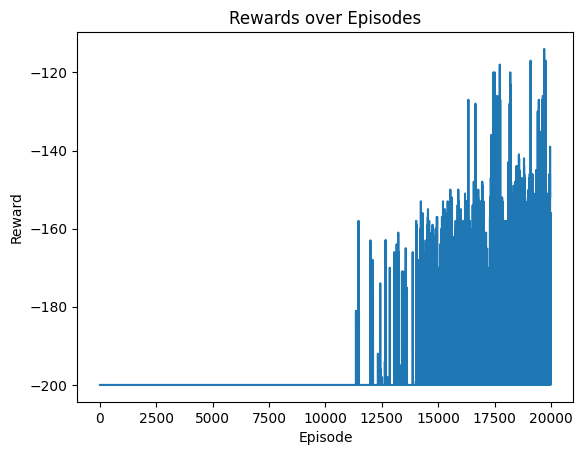

In [15]:
if __name__ == "__main__":
    # Инициализация окружения и агента
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    agent = Agent(env, config)

    # Обучение агента
    rewards = agent.train()

    # Оценка стратегии и визуализация
    import matplotlib.pyplot as plt

    plt.plot(rewards)
    plt.title("Rewards over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

    # Видеозапись работы агента
    from gymnasium.wrappers import RecordVideo

    env = RecordVideo(gym.make("MountainCar-v0", render_mode="rgb_array"), "videos", episode_trigger=lambda x: x % 100 == 0)

    for _ in range(5):
        done = False
        state, _ = env.reset()

        while not done:
            action = agent.get_action(state)
            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    env.close()

## Обратная связь
- [ ] Хочу получить обратную связь по решению